# Classe com Herança

In [10]:
import numpy as np
import tensorflow as tf
from kapre.time_frequency import ApplyFilterbank, STFT, Magnitude
from kapre import backend
import kapre
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Lambda
from kapre.backend import validate_data_format_str, _CH_DEFAULT_STR, _CH_LAST_STR, _CH_FIRST_STR

In [2]:
#_CH_FIRST_STR = 'channels_first'
#_CH_LAST_STR = 'channels_last'
#_CH_DEFAULT_STR = 'default'

In [11]:
class CustomApplyFilterbank(ApplyFilterbank):
    def __init__(self, type, filterbank_kwargs, data_format='default', **kwargs):
        super(CustomApplyFilterbank, self).__init__(type, filterbank_kwargs, data_format, **kwargs)

        # tipo de Banco de filtros
        if type == 'tri':
            self.filterbank = self.filterbank_triangular_log(**filterbank_kwargs)

        if data_format == _CH_DEFAULT_STR:
            self.data_format = K.image_data_format()
        else:
            self.data_format = data_format

        if self.data_format == _CH_FIRST_STR:
            self.freq_axis = 3
        else:
            self.freq_axis = 2

    def filterbank_triangular_log(sample_rate=8000, nfft=2048):
        # Com o objetivo de ter 256 giltros e 8000 Hz na frequência de amostragem, teve-se de optar por Nfft de 2048, o que resulta em 54.4024 filtros por oitava, e numa frequência mínima de 151.3483 Hz.
        # Sendo assim, o Nfpo será 60, 5*12, e a frequência do último filtro, f256, será Si7 = 3951.066410048992 Hz. Resultando numa frequência máxima de 3996.975590329487 Hz.
        # Com isto, obtem-se pelo menos um bin em cada filtro, visto que f0*(2^(2/Nfpo)-1) = 4.7979 > 8000/2048 = 3.9062. Para uma Nfft de 1024, não era certo que obte-se pelo menos um bin por filtro.

        nfft=2048
        sample_rate=8000
        Nfpo=60 #=5*12
        Nb =256

        #Cálculo da fmin e fmax
        f256 = 440*2.**(38/12) # Si7 = 3951.066410048992 Hz;
        f0=f256/2**(256/Nfpo) # fmin, 205.2672581380976 Hz
        fmax = f0*2**(257/Nfpo) # fmax, 3996.975590329487 Hz

        #Depois disto, dá bins em todos os fitros. Ver a linha 24 do getOctaveFilterBanck2.m

        i=np.arange(1,Nb+1, dtype=float)
        k=np.arange(nfft//2+1)
        f=k*sample_rate/nfft

        fcf = f0 * 2.**(i/Nfpo) #3905.68454168

        fi = np.concatenate(([f0], fcf, [fmax])) #fi =[f0, fcf, fmax] 

        # Construct the output matrix
        H = np.zeros((Nb, nfft // 2 + 1))

        #for i in range(n_filters), com isto são 256
        for j in range(Nb):
            fLow = fi[j] 
            fmid = fi[j+1] 
            fUpp = fi[j+2]

            H[j, :] = ((f - fLow) / (fmid - fLow)) * ((f > fLow) & (f <= fmid)) + \
                            ((f - fUpp) / (fmid - fUpp)) * ((f > fmid) & (f <= fUpp))
            

        H /= np.sum(H, axis=1, keepdims=True) # : A matriz é normalizada ao longo do eixo 1 (linhas), dividindo cada valor pela soma dos valores na respectiva linha. Isto garante que a soma de cada linha seja igual a 1.65

        return tf.convert_to_tensor(H.T, dtype=tf.float32)
        #return tf.convert_to_tensor(H.T)
    

    def call(self, x):
        output = tf.tensordot(x, self.filterbank, axes=(self.freq_axis, 0))
        
        if self.data_format == _CH_LAST_STR:
            output = tf.transpose(output, (0, 1, 3, 2))
        return output

In [12]:
# -*- coding: utf-8 -*-
"""melsprctrogram.py"""    
import tensorflow as tf
from tensorflow.keras import Model
from tensorflow.keras.layers import Permute
from kapre.time_frequency import STFT, Magnitude#, ApplyFilterbank
import math


class Melspec_layer(Model):
    """
    A wrapper class, based on the implementation:
        https://github.com/keunwoochoi/kapre
        
    Input:
        (B,1,T)
    Output:
        (B,C,T,1) with C=Number of mel-bins
    
    USAGE:
        
        See get_melspec_layer() in the below.
        
    """
    def __init__(
            self,
            input_shape=(1, 8000),
            segment_norm=False,
            n_fft=1024,
            stft_hop=256,
            n_mels=256,
            fs=8000,
            dur=1.,
            f_min=300.,
            f_max=4000.,
            amin=1e-10, # minimum amp.
            dynamic_range=80.,
            name='Mel-spectrogram',
            trainable=False,
            **kwargs
            ):
        super(Melspec_layer, self).__init__(name=name, trainable=False, **kwargs)
        
        self.mel_fb_kwargs = {
            'sample_rate': fs,
            'n_freq': n_fft // 2 + 1,
            'n_mels': n_mels,
            'f_min': f_min,
            'f_max': f_max,
            }
        self.n_fft = n_fft
        self.stft_hop = stft_hop
        self.n_mels = n_mels
        self.amin = amin
        self.dynamic_range = dynamic_range
        self.segment_norm = segment_norm
        
        # 'SAME' Padding layer
        self.pad_l = n_fft // 2
        self.pad_r = n_fft // 2
        self.padded_input_shape = (1, int(fs * dur) + self.pad_l + self.pad_r)
        self.pad_layer = Lambda(
            lambda z: tf.pad(z, tf.constant([[0, 0], [0, 0],
                                             [self.pad_l, self.pad_r]]))
            )
        
        # Construct log-power Mel-spec layer
        self.m = self.construct_melspec_layer(input_shape, name)

        # Permute layer
        self.p = tf.keras.Sequential(name='Permute')
        self.p.add(Permute((3, 2, 1), input_shape=self.m.output_shape[1:]))
        
        super(Melspec_layer, self).build((None, input_shape[0], input_shape[1]))
        
        
    def construct_melspec_layer(self, input_shape, name):
        m = tf.keras.Sequential(name=name)
        m.add(tf.keras.layers.InputLayer(input_shape=input_shape))
        m.add(self.pad_layer)
        m.add(
            STFT(
                n_fft=self.n_fft,
                hop_length=self.stft_hop,
                pad_begin=False, # We do not use Kapre's padding, due to the @tf.function compatiability
                pad_end=False, # We do not use Kapre's padding, due to the @tf.function compatiability
                input_data_format='channels_first',
                output_data_format='channels_first')
            )
        m.add(
            Magnitude()
            )
        m.add(
            CustomApplyFilterbank(type='tri',
                            filterbank_kwargs=self.mel_fb_kwargs,
                            data_format='channels_first'
                            )
            )
        return m
        

    @tf.function
    def call(self, x):        
        x = self.m(x) + 0.06
        #x = tf.sqrt(x)
        
        x = tf.math.log(tf.maximum(x, self.amin)) / math.log(10)
        x = x - tf.reduce_max(x)
        x = tf.maximum(x, -1 * self.dynamic_range)
        if self.segment_norm:
            x = (x - tf.reduce_min(x) / 2) / tf.abs(tf.reduce_min(x) / 2 + 1e-10)
        return self.p(x) # Permute((3,2,1))

    
def get_melspec_layer(cfg, trainable=False):
    fs = cfg['MODEL']['FS']
    dur = cfg['MODEL']['DUR']
    n_fft = cfg['MODEL']['STFT_WIN']
    stft_hop = cfg['MODEL']['STFT_HOP']
    n_mels = cfg['MODEL']['N_MELS']
    f_min = cfg['MODEL']['F_MIN']
    f_max = cfg['MODEL']['F_MAX']
    if cfg['MODEL']['FEAT'] == 'melspec':
        segment_norm = False
    elif cfg['MODEL']['FEAT'] == 'melspec_maxnorm':
        segment_norm = True
    else:
        raise NotImplementedError(cfg['MODEL']['FEAT'])
    
    input_shape = (1, int(fs * dur))
    l = Melspec_layer(input_shape=input_shape,
                      segment_norm=segment_norm,
                      n_fft=n_fft,
                      stft_hop=stft_hop,
                      n_mels=n_mels,
                      fs=fs,
                      dur=dur,
                      f_min=f_min,
                      f_max=f_max)
    l.trainable = trainable
    return l
                        

In [18]:
#from model.dataset import Dataset
import yaml
import os
import sys


def load_config(config_fname):
    config_filepath = './config/' + config_fname + '.yaml'
    if os.path.exists(config_filepath):
        print(f'cli: Configuration from {config_filepath}')
    else:
        sys.exit(f'cli: ERROR! Configuration file {config_filepath} is missing!!')

    with open(config_filepath, 'r') as f:
        cfg = yaml.safe_load(f)
    return cfg

config = "default"
cfg = load_config(config)
m_pre = get_melspec_layer(cfg)

m_pre(X)

dataset = Dataset(cfg)
train_ds = dataset.get_train_ds(0)

ModuleNotFoundError: No module named 'model'

In [13]:
import matplotlib.pyplot as plt
import scipy.io.wavfile as wav

def plot_spectrogram(spectrogram, fs, hop_length, y_axis="mel"):
    plt.figure(figsize=(10, 4))
    plt.imshow(spectrogram, aspect='auto', origin='lower')
    plt.colorbar(format='%+2.0f dB')
    plt.title('Mel-frequency spectrogram')
    plt.tight_layout()
    plt.show()

audio_path = '/home/rodrigo/Documents/neural-audio-fp/matlabFiles/Diatonic_scale_on_C.wav'


y = y.astype(np.float32)
y = np.expand_dims(y, axis=0)
y = np.expand_dims(y, axis=0)

spectrogram = Melspec_layer(y).numpy()
spectrogram = np.squeeze(spectrogram)

plot_spectrogram(spectrogram, fs=fs, hop_length=256, y_axis='mel')

TypeError: only integer scalar arrays can be converted to a scalar index

In [143]:
H = filterbank_triangular_log(sample_rate=8000, nfft=2048)

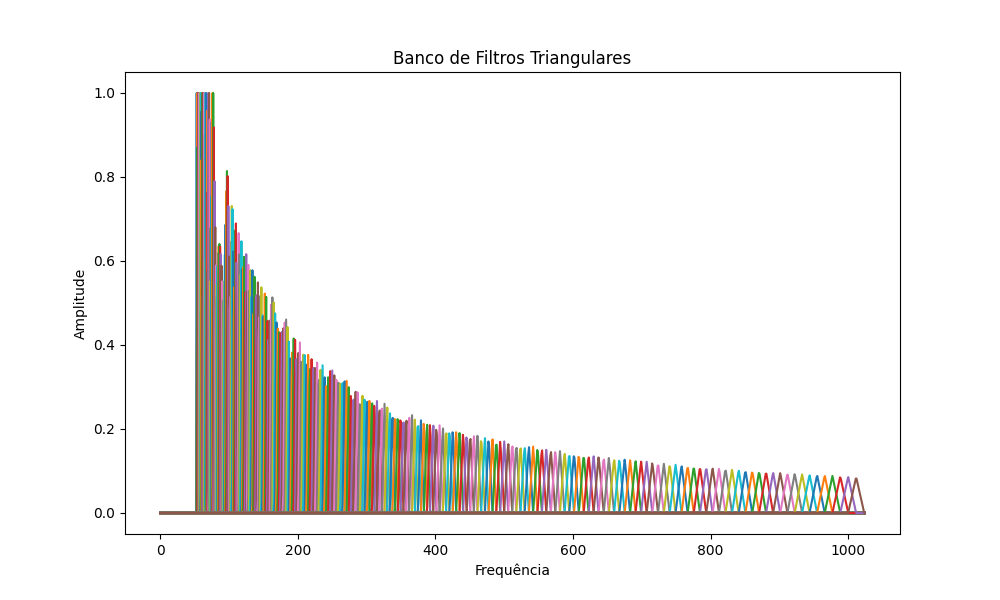

In [144]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(H)
    

plt.title('Banco de Filtros Triangulares')
plt.xlabel('Frequência')
plt.ylabel('Amplitude')
plt.show()

In [3]:
class CustomApplyFilterbank(ApplyFilterbank):
    def __init__(self, type, filterbank_kwargs, data_format='default', **kwargs):
        super(CustomApplyFilterbank, self).__init__(type, filterbank_kwargs, data_format, **kwargs)

        # tipo de Banco de filtros
        if type == 'tri':
            self.filterbank = self.filterbank_triangular(**filterbank_kwargs)

        if data_format == _CH_DEFAULT_STR:
            self.data_format = K.image_data_format()
        else:
            self.data_format = data_format

        if self.data_format == _CH_FIRST_STR:
            self.freq_axis = 3
        else:
            self.freq_axis = 2

    #def create_new_filterbank(self, **filterbank_kwargs):
    #    return self.filterbank_triangular(**filterbank_kwargs)

    
    def filterbank_triangular(self, fs=None, Nfft=None, Nfpo=None, fmin_user=None, fmax_user=None, edges=None):
        """
        filterbank_triangular() gera um banco de filtros triangulares em escala logarítmica com "Nfpo" filtros
        por oitava. Retorna as respostas em frequência dos fitros na matriz "H" bem como os valores das
        frequências centrais (vértice dos triângulos dos filtros).

        Arguments:
            fs   - frequência de amostragem do sinal de áudio. (default: 8000)
            Nfft - Número de amostras da FFT (para amostrar a resposta em frequência dos filtros)(default=1046)
            Nfpo - Número de filtros por oitava (default: 12)
            fmin_user - frequência mínima que o utilizador propõe (default: 32.7032 Hz: C1)
            fmax_user - frequência máxima que o utilizador propõe (default: 7040 Hz:    A8)
            edges - boolean; se 'edges' é True, junta ao vetor de saída fcf, os vértices do 1º e último filtro. (default: eges=False)
        
        Returns:
            H   -   matriz de dimensão Nb x Nfft/2+1 com a parte positiva das respostas em frequência dos Nb  filtros (um filtro por
                    linha de H)
            fcf  - vetor com os vétices dos filtros. Se edges='edges' junta fmin e fmax: fcf=[fmin,fcf,fmax]

        Nota: os filtros estão sobrepostos em frequência de forma que se fcf(i) for a frequência central do filtro i, é também o vértice
        superior do filtro i-1 e o vértice inferior do filtro i+1.

        A frequência fcf[i] é dada por:
                                        f[i] = f(0)*2^(i/Nfpo),
        de forma que f[0]=fmin, f[1] é a frequência central do 1º filtro, etc. f[Nfpo] = 2*f[0] e f[Nb+1]=fmax.

        Nota: as frequências centrais são ajustadas, sempre que possível, aos semitons musicais na escala temperada. Daí que fmin_user
        é apenas indicativa e pode ser diferente de fmin. O mesmo para fmax.

        Inicialmente é feito o cálculo do número de filtros (Nb) que o banco de filtros terá pelas frequências miníma (fmin_user) e
        máxima (fmax_user) dadas pelo utilizador e pelo número de filtros por oitava (Nfpo).

        O primeiro filtro tem a frequência mínima (fmin), a primeira frequência central (f1).

        A construção do Banco de Filtros dependerá de fi. Pelo que o primeiro valor de fi, será a frequência mínima do primeiro filtro
        que será usado na aplicação do Banco de Filtros, a frequência seguinte no vetor fi será a frequência central (fcf) do primeiro
        filtro. A terceira frequência do vetor fi será a frequência alta do primeiro filtro. O segundo filtro terá como frequência mínima
        a frequência central do primeiro filtro e terá como frequência central a frequência mais alta do primeiro filtro.

        Respostas dos filtros
        1          .
                /|\
                / |  \                    H(1,:)
        --------+  |   +--------------------------------->f
            fmin f1
        1              .
                    /|\
                    /  |  \                H(2,:)
        -----------+   |   +----------------------------->f
                    f2
        ...
        1                              .
                                    / | `
                                /     |    `      H(Nb,:)
        ----------------------+        |        +--------->f
                            f_Nb-1    f_Nb     fmax
        """
        #Default values
        if fs is None:
            fs=8000
        if Nfft is None:
            Nfft = 1024
        if fmin_user is None:
            fmin_user = 440*(2**(((1+1)*12+0-69)/12)) # alterar para o que tava no fmin
        if fmax_user is None:
            fmax_user = 440*(2**(((8+1)*12+9-69)/12))
        if edges is None:
            edges=False
        

        i0=int(np.ceil(Nfpo*np.log2(fmin_user/440)))  #i0_indexes=i0+69; -> 69, Lá como referência
        fmin=440*(2**(i0/Nfpo)) #Freq. Low do 1ºfiltro - não conta
        i=int(np.floor(-i0+Nfpo*(np.log2(fmax_user/440))))
        Nb=i-1
        fmax=440*(2**((i+i0)/Nfpo))
        i=np.arange(Nb + 2)
        fi = fmin*(2.**(i/Nfpo))
        k=np.arange(Nfft//2+1)
        f=k*fs/Nfft
        fcf = np.zeros(Nb)
        H = np.zeros((Nb, Nfft // 2 + 1))

        # Construção do Banco de Filtros
        for j in range(0,Nb):
            fLow = fi[j]
            fcf[j] = fi[j+1]
            fUpp = fi[j+2]

            H[j, :] = ((f - fLow) / (fcf[j] - fLow)) * ((f > fLow) & (f <= fcf[j])) + \
                        ((f - fUpp) / (fcf[j] - fUpp)) * ((f > fcf[j]) & (f <= fUpp))
            
        if edges:
            fcf = np.concatenate(([fmin], fcf, [fmax]))

        return tf.convert_to_tensor(H, dtype=tf.float32)#, fcf


    def call(self, x):
        output = tf.tensordot(x, self.filterbank, axes=(self.freq_axis, 0))
        
        if self.data_format == _CH_LAST_STR:
            output = tf.transpose(output, (0, 1, 3, 2))
        return output

In [4]:
input_shape=(1, 8000)
Nfft=1024
Nfpo=12
fs=8000
dur=1
fmin_user=300
fmax_user=4000
name='Mel-spectrogram'

mel_fb_kwargs = {
            'fs': fs,
            'Nfft': Nfft // 2 + 1,
            'Nfpo': Nfpo,
            'fmin_user': fmin_user,
            'fmax_user': fmax_user,
            }

pad_l = Nfft // 2
pad_r = Nfft // 2
padded_input_shape = (1, int(fs * dur) + pad_l + pad_r)
pad_layer = Lambda(lambda z: tf.pad(z, tf.constant([[0, 0], [0, 0],
                                        [pad_l, pad_r]]))
    )

In [5]:
m = tf.keras.Sequential(name=name)
m.add(tf.keras.layers.InputLayer(input_shape=input_shape))
m.add(pad_layer)

#alterar o STFT para o meu a seguir
m.add(
    STFT(
        n_fft=Nfft,
        hop_length=256,
        pad_begin=False, # We do not use Kapre's padding, due to the @tf.function compatiability
        pad_end=False, # We do not use Kapre's padding, due to the @tf.function compatiability
        input_data_format='channels_first',
        output_data_format='channels_first')
    )
m.add(
    Magnitude()
    )
m.add(CustomApplyFilterbank(
                        type='tri',
                        filterbank_kwargs=mel_fb_kwargs,
                        data_format='channels_first'
                        )
    )

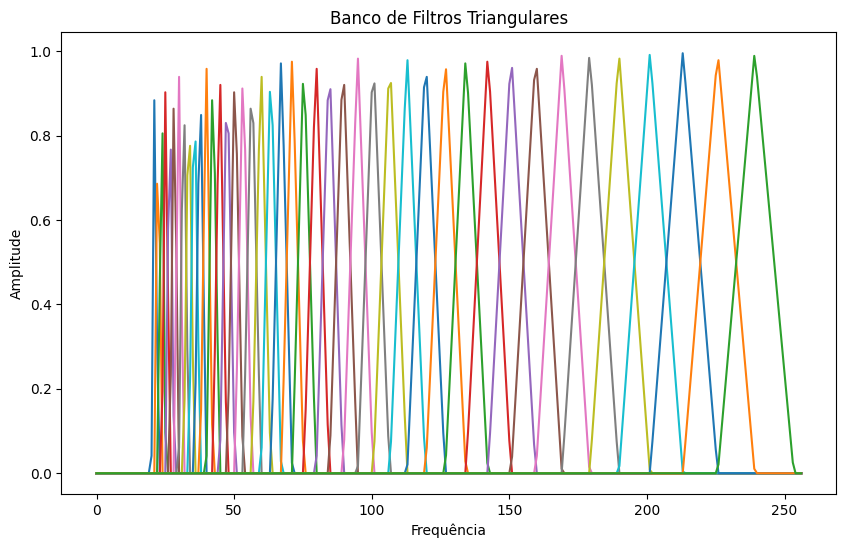

In [6]:
import matplotlib.pyplot as plt

filters = m.layers[-1].filterbank

plt.figure(figsize=(10, 6))
for i in range(filters.shape[0]):
    plt.plot(filters[i])
    

plt.title('Banco de Filtros Triangulares')
plt.xlabel('Frequência')
plt.ylabel('Amplitude')
plt.show()

normalização

In [13]:
input_shape = (1, 8000)
fs = 8000
Nfft = 1024
Nfpo=12
fmin_user=300
fmax_user=4000
edges=False
kwargs = {
    'fs': fs,
    'Nfft': Nfft,
    'Nfpo': Nfpo,
    'fmin_user': fmin_user,
    'fmax_user': fmax_user,
    'edges':edges
}

In [14]:
a=CustomApplyFilterbank('tri', kwargs, data_format='default')

In [22]:
#h=a.filterbank_triangular(fs, Nfft, Nfpo, fmin_user, fmax_user, edges)

In [24]:
h=a.filterbank_triangular(**kwargs)

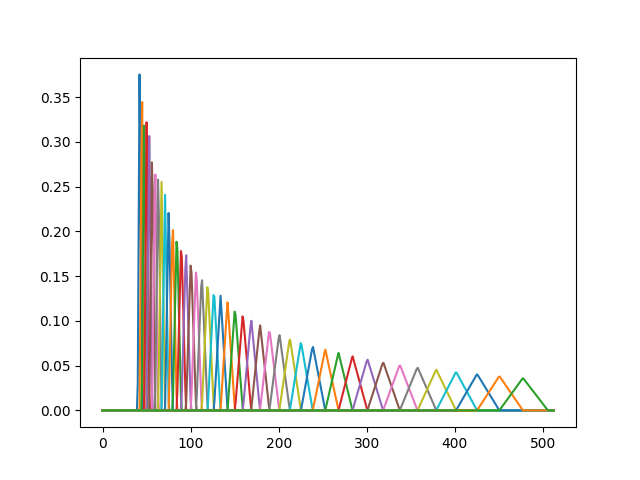

In [25]:
import librosa
%matplotlib widget
import matplotlib.pyplot as plt

plt.figure()
plt.plot(librosa.util.normalize(h, norm=1, axis=1).T)
plt.show()

In [ ]:
model = tf.keras.Sequential()
model.add(kapre.STFT(n_fft=Nfft, hop_length=Nfpo, input_shape=input_shape))
model.add(kapre.Magnitude())
model.add(CustomApplyFilterbank(type='tri', filterbank_kwargs=kwargs))

# Criação da função

In [1]:
import numpy as np

In [2]:
def filterbank_triangular(fs=None, Nfft=None, Nfpo=None, fmin_user=None, fmax_user=None, edges=None):
    """
    filterbank_triangular() gera um banco de filtros triangulares em escala logarítmica com "Nfpo" filtros
    por oitava. Retorna as respostas em frequência dos fitros na matriz "H" bem como os valores das
    frequências centrais (vértice dos triângulos dos filtros).

    Arguments:
        fs   - frequência de amostragem do sinal de áudio. (default: 8000)
        Nfft - Número de amostras da FFT (para amostrar a resposta em frequência dos filtros)(default=1046)
        Nfpo - Número de filtros por oitava (default: 12)
        fmin_user - frequência mínima que o utilizador propõe (default: 32.7032 Hz: C1)
        fmax_user - frequência máxima que o utilizador propõe (default: 7040 Hz:    A8)
        edges - boolean; se 'edges' é True, junta ao vetor de saída fcf, os vértices do 1º e último filtro. (default: eges=False)
    
    Returns:
        H   -   matriz de dimensão Nb x Nfft/2+1 com a parte positiva das respostas em frequência dos Nb  filtros (um filtro por
                linha de H)
        fcf  - vetor com os vétices dos filtros. Se edges='edges' junta fmin e fmax: fcf=[fmin,fcf,fmax]

    Nota: os filtros estão sobrepostos em frequência de forma que se fcf(i) for a frequência central do filtro i, é também o vértice
    superior do filtro i-1 e o vértice inferior do filtro i+1.

    A frequência fcf[i] é dada por:
                                    f[i] = f(0)*2^(i/Nfpo),
    de forma que f[0]=fmin, f[1] é a frequência central do 1º filtro, etc. f[Nfpo] = 2*f[0] e f[Nb+1]=fmax.

    Nota: as frequências centrais são ajustadas, sempre que possível, aos semitons musicais na escala temperada. Daí que fmin_user
    é apenas indicativa e pode ser diferente de fmin. O mesmo para fmax.

    Inicialmente é feito o cálculo do número de filtros (Nb) que o banco de filtros terá pelas frequências miníma (fmin_user) e
    máxima (fmax_user) dadas pelo utilizador e pelo número de filtros por oitava (Nfpo).

    O primeiro filtro tem a frequência mínima (fmin), a primeira frequência central (f1).

    A construção do Banco de Filtros dependerá de fi. Pelo que o primeiro valor de fi, será a frequência mínima do primeiro filtro
    que será usado na aplicação do Banco de Filtros, a frequência seguinte no vetor fi será a frequência central (fcf) do primeiro
    filtro. A terceira frequência do vetor fi será a frequência alta do primeiro filtro. O segundo filtro terá como frequência mínima
    a frequência central do primeiro filtro e terá como frequência central a frequência mais alta do primeiro filtro.

    Respostas dos filtros
    1          .
              /|\
             / |  \                    H(1,:)
    --------+  |   +--------------------------------->f
          fmin f1
    1              .
                  /|\
                /  |  \                H(2,:)
    -----------+   |   +----------------------------->f
                   f2
    ...
    1                              .
                                 ´ | `
                             ´     |    `      H(Nb,:)
    ----------------------+        |        +--------->f
                        f_Nb-1    f_Nb     fmax
    """
    #Default values
    if fs is None:
        fs=8000
    if Nfft is None:
        Nfft = 1024
    if Nfpo is None:
        Nfpo =12
    if fmin_user is None:
        fmin_user = 440*(2**(((1+1)*12+0-69)/12))
    if fmax_user is None:
        fmax_user = 440*(2**(((8+1)*12+9-69)/12))
    if edges is None:
        edges=False
    

    i0=int(np.ceil(Nfpo*np.log2(fmin_user/440)))  #i0_indexes=i0+69; -> 69, Lá como referência
    fmin=440*(2**(i0/Nfpo)) #Freq. Low do 1ºfiltro - não conta
    i=int(np.floor(-i0+Nfpo*(np.log2(fmax_user/440))))
    Nb=i-1
    fmax=440*(2**((i+i0)/Nfpo))
    i=np.arange(Nb + 2)
    fi = fmin*(2.**(i/Nfpo))
    k=np.arange(Nfft//2+1)
    f=k*fs/Nfft
    fcf = np.zeros(Nb)
    H = np.zeros((Nb, Nfft // 2 + 1))

    # Construção do Banco de Filtros
    for j in range(0,Nb):
        fLow = fi[j]
        fcf[j] = fi[j+1]
        fUpp = fi[j+2]

        H[j, :] = ((f - fLow) / (fcf[j] - fLow)) * ((f > fLow) & (f <= fcf[j])) + \
                    ((f - fUpp) / (fcf[j] - fUpp)) * ((f > fcf[j]) & (f <= fUpp))
        
    if edges:
        fcf = np.concatenate(([fmin], fcf, [fmax]))

    return H, fcf

In [3]:
fs = 8000
Nfft = 1024
Nfpo=12
fmin_user=300
fmax_user=4000
edges=False

In [4]:
kwargs ={
    'fs':fs,
    'Nfft':Nfft,
    'Nfpo':Nfpo,
    'fmin_user':fmin_user,
    'fmax_user':fmax_user,
    'edges':edges
} 

In [5]:
H, fcf= filterbank_triangular(**kwargs)

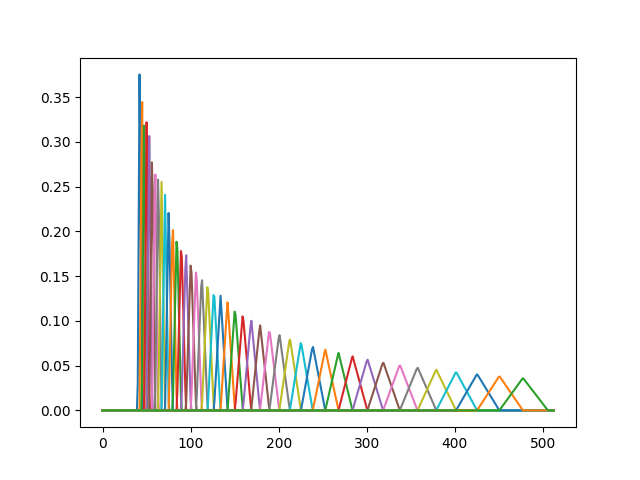

In [6]:
plt.figure()
plt.plot(librosa.util.normalize(H, norm=1, axis=1).T)
plt.show()